## Imports

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import alc

## Cargamos el dataset

In [18]:
X_train, Y_train, X_val, Y_val = alc.cargarDataset("cats_and_dogs/")

print(X_train.shape, Y_train.shape)  # (1536, 3000) (2, 3000)
print(X_val.shape, Y_val.shape)      # (1536, 2000) (2, 2000)

(1536, 2000) (2, 2000)
(1536, 1000) (2, 1000)


## Calculamos la W con distintos metodos

### Método 1: Cholesky

In [19]:
N, M = X_train.shape
Xc = X_train.copy().astype(np.float64)
Yc = Y_train.copy().astype(np.float64)

if N == M:
    pXchols = alc.inversa(Xc)
    Wchols = alc.prodMat(Yc, pXchols)
else:
    if N > M:
        # print("Caso (a) N > M")
        Xh = alc.prodMat(Xc.T, Xc) 
    else:
        # print("Caso (b) N < M")
        Xh = alc.prodMat(Xc, Xc.T)
    # print("Calculo de Cholesky")
    L = alc.calculaCholesky(Xh)

    Wchols = alc.pinvEcuacionesNormales(X_train,L,Y_train)

### Método 2: QR de Householder

In [20]:
N, M = X_train.shape
Xc = X_train.copy().astype(np.float64)
Yc = Y_train.copy().astype(np.float64)

# Hace con @ para poder evaluar, en el modulo esta la version sin @
Q, R = alc.QR_con_HH_NP(Xc.T)

Whh = alc.pinvHouseHolder(Q, R, Yc)

### Método 3: QR de Gram-Schmidt 

In [21]:
N, M = X_train.shape
Xc = X_train.copy().astype(np.float64)
Yc = Y_train.copy().astype(np.float64)

Q, R = alc.QR_con_GS(Xc.T)

Wgm = alc.pinvGramSchmidt(Q, R, Yc)

### Método 4: SVD

In [22]:
N, M = X_train.shape
Xc = X_train.copy().astype(np.float64)
Yc = Y_train.copy().astype(np.float64)

U, S, V = alc.svd_reducida_np(Xc)

Wsvd = alc.pinvSVD(U, S, V, Yc)

## Evaluamos los resultados

### Calculamos las predicciones de cada método

In [23]:
# Generar predicciones de cada uno
Y_pred_svd = alc.prodMat(Wsvd, X_val)
Y_pred_chols = alc.prodMat(Wchols, X_val)
Y_pred_gm = alc.prodMat(Wgm, X_val)
Y_pred_hh = alc.prodMat(Whh, X_val)

### Matriz de confusión de cada método

#### Cholesky

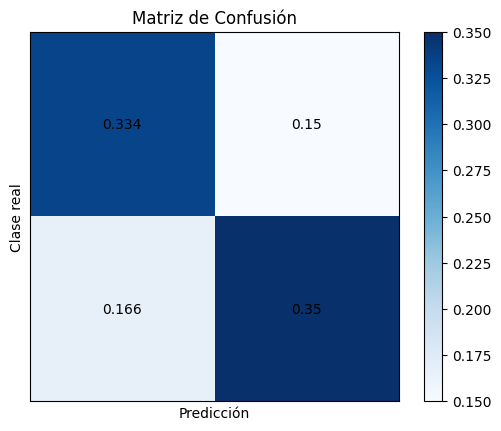

Matriz de confusión:
 [[0.334 0.15 ]
 [0.166 0.35 ]]
Accuracy Cholesky: 0.684


In [24]:
M_chols, acc_chols = alc.matriz_confusion(Y_pred_chols, Y_val)
print("Matriz de confusión:\n", M_chols)
print("Accuracy Cholesky:", acc_chols)

#### QR de Gram-Schmidt

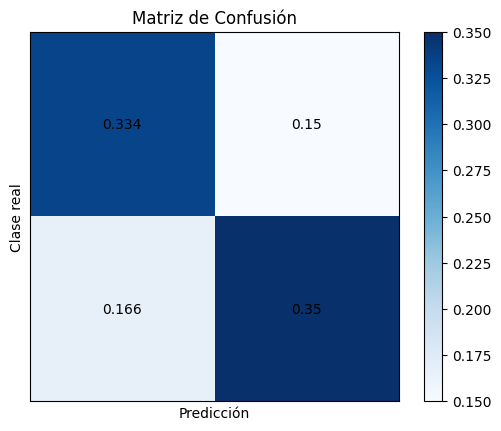

Matriz de confusión:
 [[0.334 0.15 ]
 [0.166 0.35 ]]
Accuracy QR (Gram-Schmidt): 0.684


In [25]:
M_gm, acc_gm = alc.matriz_confusion(Y_pred_gm, Y_val)
print("Matriz de confusión:\n", M_gm)
print("Accuracy QR (Gram-Schmidt):", acc_gm)

#### QR de Householder

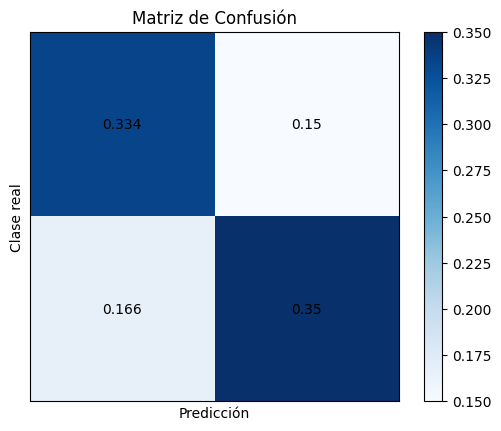

Matriz de confusión:
 [[0.334 0.15 ]
 [0.166 0.35 ]]
Accuracy QR (Householder): 0.684


In [26]:
M_hh, acc_hh = alc.matriz_confusion(Y_pred_hh, Y_val)
print("Matriz de confusión:\n", M_hh)
print("Accuracy QR (Householder):", acc_hh)

#### SVD

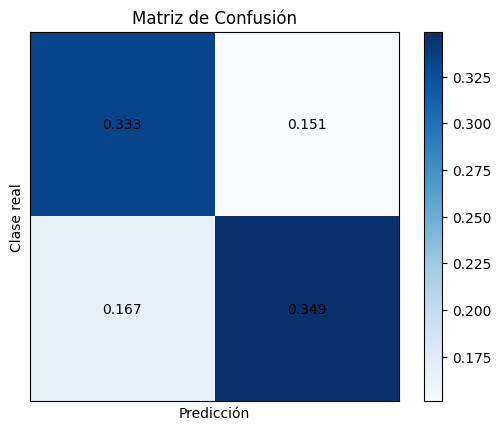

Matriz de confusión:
 [[0.333 0.151]
 [0.167 0.349]]
Accuracy SVD: 0.682


In [27]:
# Predicciones del algoritmo con SVD
M_svd, acc_svd = alc.matriz_confusion(Y_pred_svd, Y_val)
print("Matriz de confusión:\n", M_svd)
print("Accuracy SVD:", acc_svd)

### Graficamos los resultados

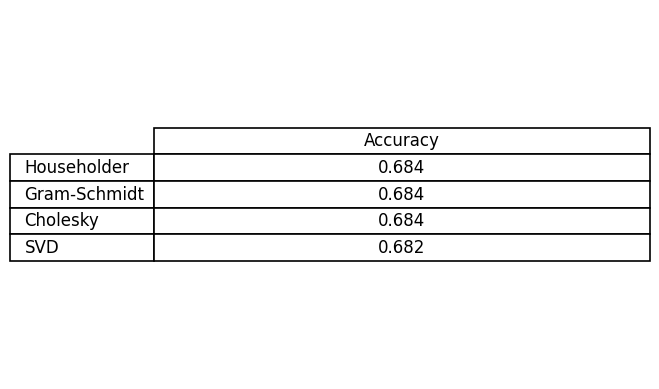

In [28]:
rows = ["Householder", "Gram-Schmidt", "Cholesky", "SVD"]
values = [acc_hh, acc_gm, acc_chols, acc_svd]

fig, ax = plt.subplots()
ax.axis('off')

# Crear tabla
table = ax.table(
    cellText=[[v] for v in values],
    rowLabels=rows,
    colLabels=["Accuracy"],
    loc="center",
    cellLoc="center"   # centra el contenido
)

# Ajustes de estilo
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.6)

# Agregar bordes a TODAS las celdas (incluida la esquina)
for key, cell in table.get_celld().items():
    cell.set_linewidth(1.2)

plt.show()

### EXTRA: Comparar W con la obtendida con operaciones de numpy

In [29]:
# Calcular con numpy pseudoinversa de X_train
X_pinv_np = np.linalg.pinv(X_train)
W_np = np.dot(Y_train, X_pinv_np)

# Medir distancia entre W_np y los otros W
dist_chols = np.linalg.norm(W_np - Wchols)
dist_gm = np.linalg.norm(W_np - Wgm)
dist_hh = np.linalg.norm(W_np - Whh)
dist_svd = np.linalg.norm(W_np - Wsvd)

print("Distancia entre W_np y Wchols:", dist_chols)
print("Distancia entre W_np y Wgm:", dist_gm)
print("Distancia entre W_np y Whh:", dist_hh)
print("Distancia entre W_np y Wsvd:", dist_svd)

Distancia entre W_np y Wchols: 6.704800495108116e-13
Distancia entre W_np y Wgm: 1.5583702680341006e-13
Distancia entre W_np y Whh: 6.861604479144481e-13
Distancia entre W_np y Wsvd: 0.021619115058350163
